In [1]:
! pip install faker numpy pandas scikit-learn imbalanced-learn matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.3 MB)


In [2]:
# install libs
import pandas as pd
import numpy as np
import random
from faker import Faker
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,roc_curve
from imblearn.over_sampling import SMOTE

In [3]:
# syntectic data genrator
fake = Faker()
num_records = 2000

data = {
    'CustomerID': [fake.uuid4() for _ in range(num_records)], # Random chars (unknown & just Ignore)
    'Age': [random.randint(18, 75) for _ in range(num_records)],
    'Income': [random.randint(20000, 150000) for _ in range(num_records)],
    'CreditLimit': [random.randint(5000, 50000) for _ in range(num_records)],
    'CreditUtilization': [random.uniform(0, 1) for _ in range(num_records)],
    'LatePayments': [random.randint(0, 10) for _ in range(num_records)],
    'LoanAmount': [random.randint(0, 100000) for _ in range(num_records)],
    'LoanTenure': [random.randint(1, 60) for _ in range(num_records)],
    'CreditAge': [random.randint(1, 300) for _ in range(num_records)], # in months
    'NumCreditLines': [random.randint(1, 10) for _ in range(num_records)],
    'CreditInquiries': [random.randint(0, 5) for _ in range(num_records)],
    'Defaulted': [random.choice([0, 1]) for _ in range(num_records)] # 0: No default, 1: Default
}

df = pd.DataFrame(data)

df

,CustomerID,Age,Income,CreditLimit,CreditUtilization,LatePayments,LoanAmount,LoanTenure,CreditAge,NumCreditLines,CreditInquiries,Defaulted
0,2777b255-7cc7-4388-9e95-6ef7fc81dc10,38,126591,30456,0.662755,1,33557,9,276,5,1,0
1,ed2d60c2-8271-4b25-8e70-7f0f5ee9b153,33,65159,40386,0.343908,4,75214,16,227,3,0,0
2,4afebbf9-07ae-4d16-babe-6ff7aa837cfd,73,80542,13461,0.107749,0,34776,32,33,9,1,1
3,7b94b998-4275-4115-bbe9-7bbbe1056c7d,51,20296,28662,0.718476,0,6682,4,18,4,5,1
4,6157b473-7928-4d42-b47e-2f57d012da2f,38,66689,46569,0.180081,3,44082,54,273,6,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,c6b05c18-9b05-4137-ac84-bf1d5f073e11,35,54094,10188,0.267466,6,58605,29,11,2,2,0
1996,a52d03c5-dfa8-4269-9856-08d3152a9c73,29,56775,45206,0.195230,10,60262,51,274,3,0,0
1997,8169bb99-d0f8-4f9b-b606-7f85bd9c8525,54,21966,20492,0.680904,1,11796,51,120,2,1,0
1998,d01d278e-9414-4075-b294-615c87d5f18e,35,121667,30144,0.621828,3,78675,5,210,1,1,0


In [4]:
df['LatePaymentRatio'] = df['LatePayments'] / (df['LoanTenure'] + 1)  # +1 to avoid division by zero
df['DebtToIncomeRatio'] = df['LoanAmount'] / df['Income']
df['AverageCreditAge'] = df['CreditAge'] / (df['NumCreditLines'] + 1)  # +1 to avoid zero division

In [5]:
# Binning Credit Age to categories
bins = [0, 60, 120, 180, 240, 300]
labels = ['0-5 years', '5-10 years', '10-15 years', '15-20 years', '20-25 years']
df['Credit Age Category'] = pd.cut(df['CreditAge'], bins=bins, labels=labels, right=False)

In [7]:
# if req (optional) , only for better understandings of terms 
df = df.rename(columns={
    'LatePayments': 'Late_Payments_Count',
    'CreditUtilization': 'Credit_Utilization_Ratio',
    'DebtToIncomeRatio': 'Debt-to-Income Ratio',
    'NumCreditLines': 'Number of Credit Lines'
})
df.head()

,CustomerID,Age,Income,CreditLimit,Credit_Utilization_Ratio,Late_Payments_Count,LoanAmount,LoanTenure,CreditAge,Number of Credit Lines,CreditInquiries,Defaulted,LatePaymentRatio,Debt-to-Income Ratio,AverageCreditAge,Credit Age Category
0,2777b255-7cc7-4388-9e95-6ef7fc81dc10,38,126591,30456,0.662755,1,33557,9,276,5,1,0,0.100000,0.265082,46.00,20-25 years
1,ed2d60c2-8271-4b25-8e70-7f0f5ee9b153,33,65159,40386,0.343908,4,75214,16,227,3,0,0,0.235294,1.154315,56.75,15-20 years
2,4afebbf9-07ae-4d16-babe-6ff7aa837cfd,73,80542,13461,0.107749,0,34776,32,33,9,1,1,0.000000,0.431775,3.30,0-5 years
3,7b94b998-4275-4115-bbe9-7bbbe1056c7d,51,20296,28662,0.718476,0,6682,4,18,4,5,1,0.000000,0.329227,3.60,0-5 years
4,6157b473-7928-4d42-b47e-2f57d012da2f,38,66689,46569,0.180081,3,44082,54,273,6,3,1,0.054545,0.661009,39.00,20-25 years


In [8]:
# preprocessing 

# remove not actual need columns
df_model = df.drop(columns=['CustomerID'])

# define numerical vals
categorical_features = ['Credit Age Category']
numerical_features = [col for col in df_model.columns if col not in categorical_features + ['Defaulted']]

# pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),  
    ('cat', OneHotEncoder(drop='first'), categorical_features)  
])

In [9]:
X = df_model.drop(columns=['Defaulted'])
y = df_model['Defaulted']
X_transformed = preprocessor.fit_transform(X)

print(f"Transformed feature shape: {X_transformed.shape}")

Transformed feature shape: (2000, 18)


In [10]:
# apply smoke 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
Defaulted
0    1018
1    1018
Name: count, dtype: int64


In [11]:
# Training
# 80% train - 20% test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [12]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.43      0.47       212
           1       0.48      0.56      0.52       196

    accuracy                           0.50       408
   macro avg       0.50      0.50      0.49       408
weighted avg       0.50      0.50      0.49       408


AUC-ROC Score: 0.47172217943781286

Confusion Matrix:
[[ 92 120]
 [ 86 110]]


In [13]:
cibil_min, cibil_max = 300, 900
y_test_cibil = cibil_min + (y_prob - y_prob.min()) * (cibil_max - cibil_min) / (y_prob.max() - y_prob.min())

# Display first few predicted scores
print("Sample CIBIL Scores:")
print(y_test_cibil[:10])

Sample CIBIL Scores:
[396.09514112 500.71749394 576.61837029 502.70433618 760.51424623
 669.58551342 544.47059256 670.78291433 496.19867219 604.45579344]


Top 10 Factors Contributing to the Credit Score:
                            Feature  Contribution (%)
17          Credit Age Category_nan         31.516018
16   Credit Age Category_5-10 years         10.719657
13  Credit Age Category_10-15 years         10.024363
1                            Income          9.145728
11             Debt-to-Income Ratio          8.017089
9                   CreditInquiries          4.046750
2                       CreditLimit          3.277469
12                 AverageCreditAge          3.216449
10                 LatePaymentRatio          3.118899
14  Credit Age Category_15-20 years          3.111947


/tmp/ipykernel_598/3430501398.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contribution (%)', y='Feature', data=feature_importance.sort_values(by='Contribution (%)', ascending=False).head(10), palette='coolwarm')


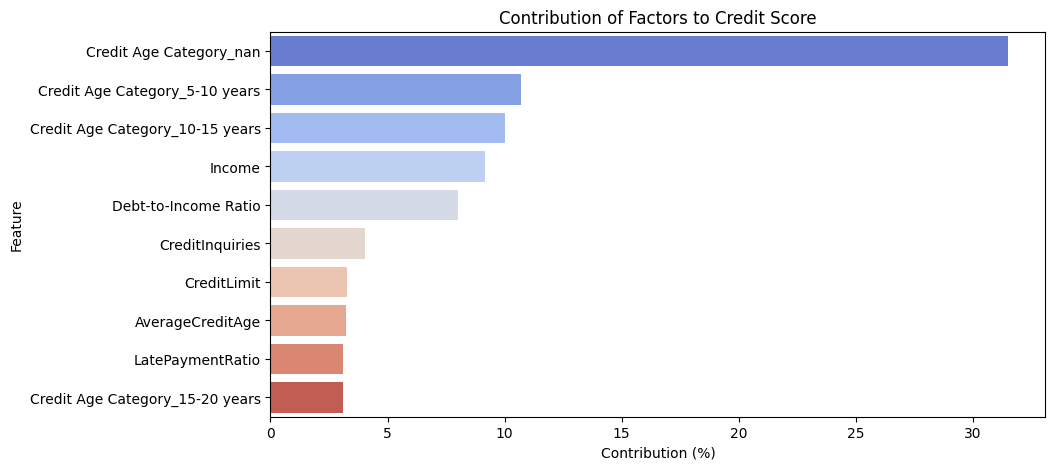

In [15]:
# Calculate feature importance using the coefficients of the Logistic Regression model
feature_importance = pd.DataFrame({
	'Feature': numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out()),
	'Importance': model.coef_[0]
})

# Calculate absolute importance and contribution percentage
feature_importance['Absolute_Importance'] = feature_importance['Importance'].abs()
feature_importance['Contribution (%)'] = (feature_importance['Absolute_Importance'] / feature_importance['Absolute_Importance'].sum()) * 100

# Display the contribution of top 10 factors
print("Top 10 Factors Contributing to the Credit Score:")
print(feature_importance[['Feature', 'Contribution (%)']].sort_values(by='Contribution (%)', ascending=False).head(10))

# Plot contribution of factors
plt.figure(figsize=(10, 5))
sns.barplot(x='Contribution (%)', y='Feature', data=feature_importance.sort_values(by='Contribution (%)', ascending=False).head(10), palette='coolwarm')
plt.xlabel('Contribution (%)')
plt.ylabel('Feature')
plt.title('Contribution of Factors to Credit Score')
plt.show()

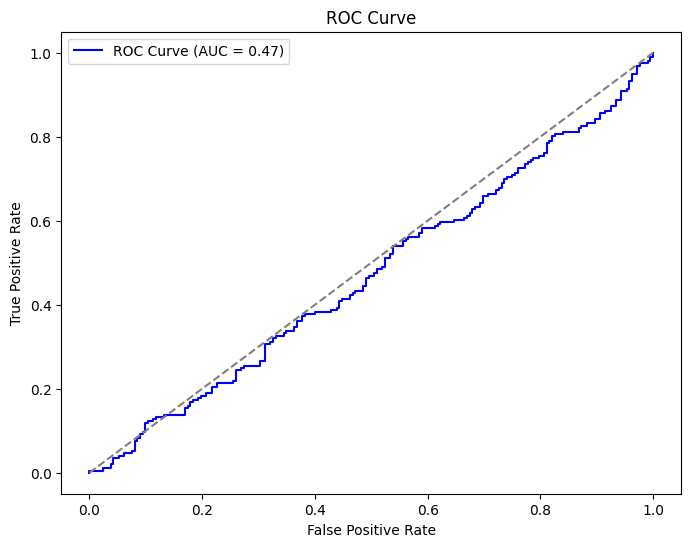

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

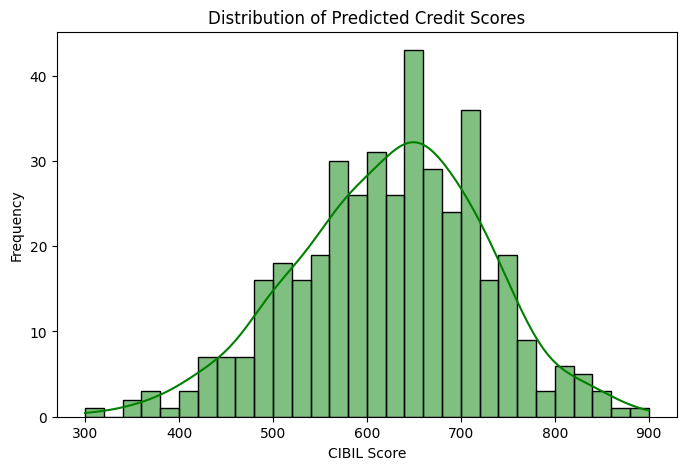

In [17]:
# score distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_test_cibil, bins=30, kde=True, color='green')
plt.xlabel('CIBIL Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Credit Scores')
plt.show()